<a href="https://colab.research.google.com/github/nawaltahir/DevelopersHub_Corporation/blob/main/House_Price_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform
import lightgbm as lgb

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive/')

# Load dataset (replace with your dataset)
data = pd.read_csv('/content/drive/MyDrive/Housing.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Pre-Processing

In [ ]:
data[["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]] = (
    data[["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]].replace({"yes": 1, "no": 0})
)
data[["furnishingstatus"]] = data[["furnishingstatus"]].replace({"furnished": 1, "semi-furnished": 0.5, "unfurnished": 0})
data.info()
data.to_csv('modified_house_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    int64  
 1   area              545 non-null    int64  
 2   bedrooms          545 non-null    int64  
 3   bathrooms         545 non-null    int64  
 4   stories           545 non-null    int64  
 5   mainroad          545 non-null    int64  
 6   guestroom         545 non-null    int64  
 7   basement          545 non-null    int64  
 8   hotwaterheating   545 non-null    int64  
 9   airconditioning   545 non-null    int64  
 10  parking           545 non-null    int64  
 11  prefarea          545 non-null    int64  
 12  furnishingstatus  545 non-null    float64
dtypes: float64(1), int64(12)
memory usage: 55.5 KB


In [ ]:
encoder= LabelEncoder()
data['furnishingstatus'] = encoder.fit_transform(data['furnishingstatus'])
encoding_col=['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']
for col in encoding_col:
  data[col] = encoder.fit_transform(data[col])
data.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,232,3,1,2,1,0,0,0,1,2,1,2
1,12250000,260,3,3,3,1,0,0,0,1,3,0,2
2,12250000,268,2,1,1,1,0,1,0,0,2,1,1
3,12215000,237,3,1,1,1,0,1,0,1,3,1,2
4,11410000,232,3,0,1,1,1,1,0,1,2,0,2
5,10850000,237,2,2,0,1,0,1,0,1,2,1,1
6,10150000,256,3,2,3,1,0,0,0,1,2,1,1
7,10150000,283,4,2,1,1,0,0,0,0,0,0,0
8,9870000,249,3,0,1,1,1,1,0,1,2,1,2
9,9800000,172,2,1,3,1,1,0,0,1,1,1,0


# Feature Engineering

In [ ]:
# Select features and target variable
X = data[['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']]  # Replace with actual feature columns
y = data['price']  # Target column (house price)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,232,3,1,2,1,0,0,0,1,2,1,2
1,12250000,260,3,3,3,1,0,0,0,1,3,0,2
2,12250000,268,2,1,1,1,0,1,0,0,2,1,1
3,12215000,237,3,1,1,1,0,1,0,1,3,1,2
4,11410000,232,3,0,1,1,1,1,0,1,2,0,2


In [ ]:
# Check for duplicate entries
duplicate_rows = data[data.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 0


In [ ]:

# Define features and target
X = data.drop(columns=['price'])
y = data['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)



# Model Selection, Training, Evalution and Fine Tuning

In [ ]:
# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"XGBoost Model MAPE: {mape_xgb * 100:.2f}%")

XGBoost Model MAPE: 22.59%


In [ ]:
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        #MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_percentage_error'])
    return model

# Create and train the CNN model
cnn_model = create_cnn_model((X_train_scaled.shape[1], 1))

# Train with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error',
                                                  patience=10,
                                                  restore_best_weights=True)

history = cnn_model.fit(X_train_scaled, y_train,
                        epochs=100,
                        batch_size=16,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=1)

# Prepare the test data for prediction
X_test_scaled_reshaped = np.expand_dims(X_test_scaled, axis=-1)
print("X_test_scaled_reshaped shape:", X_test_scaled_reshaped.shape)

# Predict and calculate MAPE
y_pred_cnn = cnn_model.predict(X_test_scaled_reshaped)
print("y_pred_cnn shape:", y_pred_cnn.shape)

# Flatten y_pred_cnn for MAPE calculation
y_pred_cnn = y_pred_cnn.flatten()
mape_cnn = mean_absolute_percentage_error(y_test, y_pred_cnn)
print(f"CNN Model MAPE: {mape_cnn * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 25236839858176.0000 - mean_absolute_percentage_error: 99.9999 - val_loss: 24781195837440.0000 - val_mean_absolute_percentage_error: 99.9990
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25779054313472.0000 - mean_absolute_percentage_error: 99.9973 - val_loss: 24774027771904.0000 - val_mean_absolute_percentage_error: 99.9820
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24523348901888.0000 - mean_absolute_percentage_error: 99.9668 - val_loss: 24721926127616.0000 - val_mean_absolute_percentage_error: 99.8584
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26226708185088.0000 - mean_absolute_percentage_error: 99.7831 - val_loss: 24486629867520.0000 - val_mean_absolute_percentage_error: 99.2984
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24190897881088.0000 - mean_absolute_percentage_error: 99.0313 - val_loss: 23706575306752.0000 - val_mean_absolute_percentage_error: 97.4231
Epoc

In [ ]:
# prompt: add force row wise=true to the light GBM model to remove over head

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform
import lightgbm as lgb
from google.colab import drive

drive.mount('/content/drive/')

# Load dataset (replace with your dataset)
data = pd.read_csv('/content/drive/MyDrive/Housing.csv')
# # Pre-Processing
data[["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]] = (
    data[["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]].replace({"yes": 1, "no": 0})
)
data[["furnishingstatus"]] = data[["furnishingstatus"]].replace({"furnished": 1, "semi-furnished": 0.5, "unfurnished": 0})
data.info()
data.to_csv('modified_house_data.csv', index=False)
encoder= LabelEncoder()
data['furnishingstatus'] = encoder.fit_transform(data['furnishingstatus'])
encoding_col=['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']
for col in encoding_col:
  data[col] = encoder.fit_transform(data[col])
data.head(10)
# # Feature Engineering
# Select features and target variable
X = data[['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']]  # Replace with actual feature columns
y = data['price']  # Target column (house price)
data.info()
data.head()
# Check for duplicate entries
duplicate_rows = data[data.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Define features and target
X = data.drop(columns=['price'])
y = data['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)


# # Model Selection, Training, Evalution and Fine Tuning
# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"XGBoost Model MAPE: {mape_xgb * 100:.2f}%")
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        #MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_percentage_error'])
    return model

# Create and train the CNN model
cnn_model = create_cnn_model((X_train_scaled.shape[1], 1))

# Train with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_percentage_error',
                                                  patience=10,
                                                  restore_best_weights=True)

history = cnn_model.fit(X_train_scaled, y_train,
                        epochs=100,
                        batch_size=16,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=1)

# Prepare the test data for prediction
X_test_scaled_reshaped = np.expand_dims(X_test_scaled, axis=-1)
print("X_test_scaled_reshaped shape:", X_test_scaled_reshaped.shape)

# Predict and calculate MAPE
y_pred_cnn = cnn_model.predict(X_test_scaled_reshaped)
print("y_pred_cnn shape:", y_pred_cnn.shape)

# Flatten y_pred_cnn for MAPE calculation
y_pred_cnn = y_pred_cnn.flatten()
mape_cnn = mean_absolute_percentage_error(y_test, y_pred_cnn)
print(f"CNN Model MAPE: {mape_cnn * 100:.2f}%")

# LightGBM Model
lgb_model = lgb.LGBMRegressor(force_row_wise=True)  # Add force_row_wise=True
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb)
print(f"LightGBM Model MAPE: {mape_lgb * 100:.2f}%")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    int64  
 1   area              545 non-null    int64  
 2   bedrooms          545 non-null    int64  
 3   bathrooms         545 non-null    int64  
 4   stories           545 non-null    int64  
 5   mainroad          545 non-null    int64  
 6   guestroom         545 non-null    int64  
 7   basement          545 non-null    int64  
 8   hotwaterheating   545 non-null    int64  
 9   airconditioning   545 non-null    int64  
 10  parking           545 non-null    int64  
 11  prefarea          545 non-null    int64  
 12  furnishingstatus  545 non-null    float64
dtypes: float64(1), int64(12)
memory usage: 55.5 KB
<class 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 25196318687232.0000 - mean_absolute_percentage_error: 99.9999 - val_loss: 24781141311488.0000 - val_mean_absolute_percentage_error: 99.9989
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23498093232128.0000 - mean_absolute_percentage_error: 99.9970 - val_loss: 24773765627904.0000 - val_mean_absolute_percentage_error: 99.9810
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26088229044224.0000 - mean_absolute_percentage_error: 99.9653 - val_loss: 24721628332032.0000 - val_mean_absolute_percentage_error: 99.8541
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25000234975232.0000 - mean_absolute_percentage_error: 99.7747 - val_loss: 24487718289408.0000 - val_mean_absolute_percentage_error: 99.2828
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26581873459200.0000 - mean_absolute_percentage_error: 99.0219 - val_loss: 23728001908736.0000 - val_mean_absolute_percentage_error: 97.4062
Epoch 6/100
22/2

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
y_pred_cnn shape: (109, 1)
CNN Model MAPE: 26.03%
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 436, number of used features: 12
[LightGBM] [Info] Start training from score 4706527.385321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [ ]:
# Define a smaller parameter distribution
param_dist = {
    'learning_rate': uniform(0.01, 0.05),
    'n_estimators': [500],
    'max_depth': [5, 7],
    'num_leaves': [20, 30],
    'min_child_samples': [20],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Perform randomized search with fewer iterations and folds
random_search = RandomizedSearchCV(estimator=lgb.LGBMRegressor(random_state=42),
                                    param_distributions=param_dist,
                                    n_iter=10,  # Reduce number of iterations
                                    scoring='neg_mean_absolute_percentage_error',
                                    cv=2,  # Reduce number of folds
                                    verbose=1,
                                    n_jobs=-1,
                                    random_state=42)

# Fit randomized search
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best model with early stopping
best_model = lgb.LGBMRegressor(
    **best_params,
    random_state=42,
    force_row_wise=True
)

# Create validation set for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit with early stopping
best_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    eval_metric='mape',
    #early_stopping_rounds=50,
    #verbose=False
)

# Predict and calculate MAPE
y_pred_lgb = best_model.predict(X_test)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb)
print(f"Might GBM Model MAPE: {mape_lgb * 100:.2f}%")


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 436, number of used features: 12
[LightGBM] [Info] Start training from score 4706527.385321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize and train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
# Reshape X_train_scaled to 2D for KNN
X_train_scaled_2D = X_train_scaled.reshape(X_train_scaled.shape[0], -1)

knn_model.fit(X_train_scaled_2D, y_train) # Use reshaped data for training

# Predict and evaluate
# Reshape X_test_scaled to 2D
X_test_scaled_2D = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
y_pred_knn = knn_model.predict(X_test_scaled_2D) # Use reshaped data for prediction
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
print(f"KNN Model MAPE: {mape_knn * 100:.2f}%")

KNN Model MAPE: 21.77%


In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
# Reshape X_train_scaled to 2D for Linear Regression
X_train_scaled_2D = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
lr_model.fit(X_train_scaled_2D, y_train)

# Predict and evaluate
# Reshape X_test_scaled to 2D
X_test_scaled_2D = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
y_pred_lr = lr_model.predict(X_test_scaled_2D)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print(f"Linear Regression Model MAPE: {mape_lr * 100:.2f}%")

Linear Regression Model MAPE: 21.43%


# Model Visulization

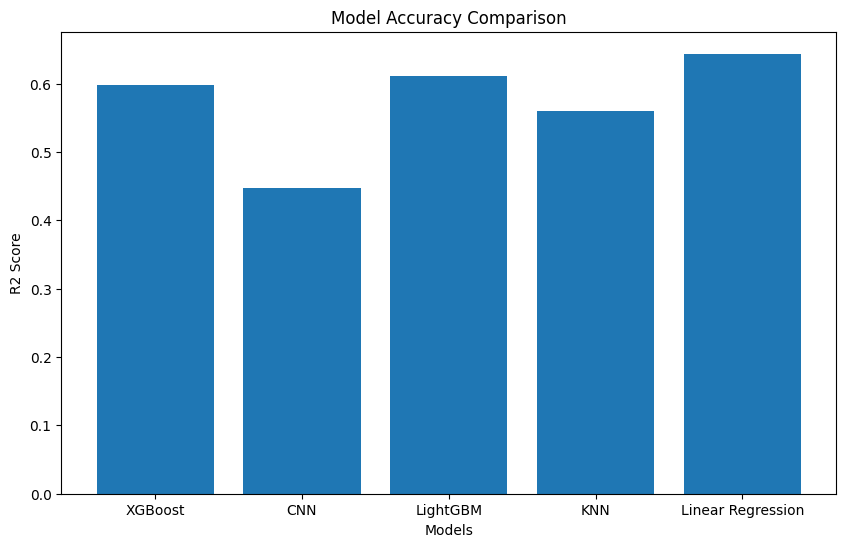

{'XGBoost': 0.5981314037107378, 'CNN': 0.4470539657405904, 'LightGBM': 0.6112091935665807, 'KNN': 0.5604016218274994, 'Linear Regression': 0.6436849068213661}


In [ ]:
import matplotlib.pyplot as plt

# Calculate R2 scores
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_cnn = r2_score(y_test, y_pred_cnn)
r2_lgb = r2_score(y_test, y_pred_lgb)
r2_knn = r2_score(y_test, y_pred_knn)
r2_lr = r2_score(y_test, y_pred_lr)

# Create a dictionary to store the R2 scores
model_scores = {
    'XGBoost': r2_xgb,
    'CNN': r2_cnn,
    'LightGBM': r2_lgb,
    'KNN': r2_knn,
    'Linear Regression': r2_lr
}

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_scores.keys(), model_scores.values())
plt.xlabel("Models")
plt.ylabel("R2 Score")
plt.title("Model Accuracy Comparison")
plt.show()

print(model_scores)

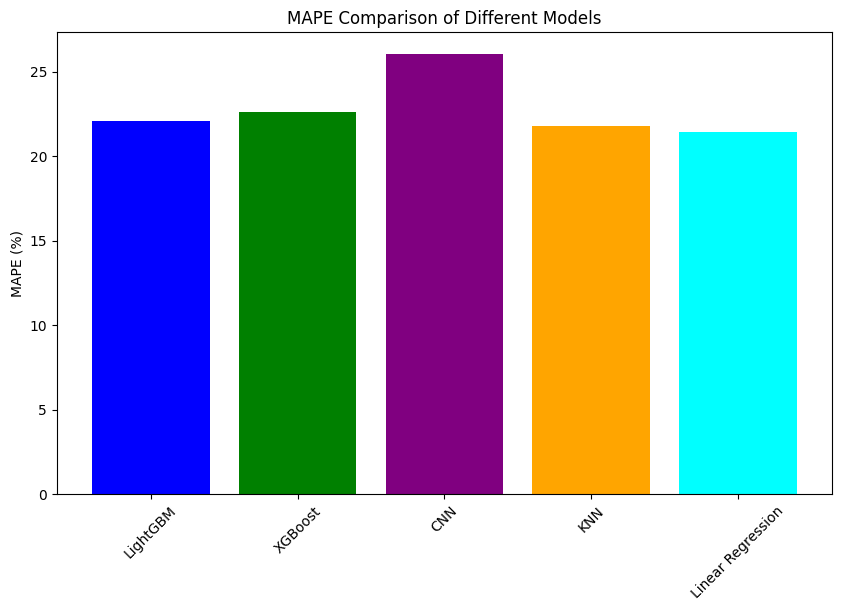

In [ ]:
import matplotlib.pyplot as plt

# MAPE values
mape_values = [mape_lgb * 100, mape_xgb * 100, mape_cnn * 100, mape_knn * 100, mape_lr * 100]
models = ['LightGBM', 'XGBoost', 'CNN', 'KNN', 'Linear Regression']

# Plot MAPE
plt.figure(figsize=(10,6))
plt.bar(models, mape_values, color=['blue', 'green', 'purple', 'orange', 'cyan'])
plt.title('MAPE Comparison of Different Models')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
plt.show()

After analyzing the accuracy and mean absolute percentage error (MAPE) of all the models it can be consluded that Linear Regression and Light GBM model provides better performace than other model therefore moving forward we will analyze their house price prediction accuracy for the provided dataset using differnt ploting methods.

**Parity Plot**

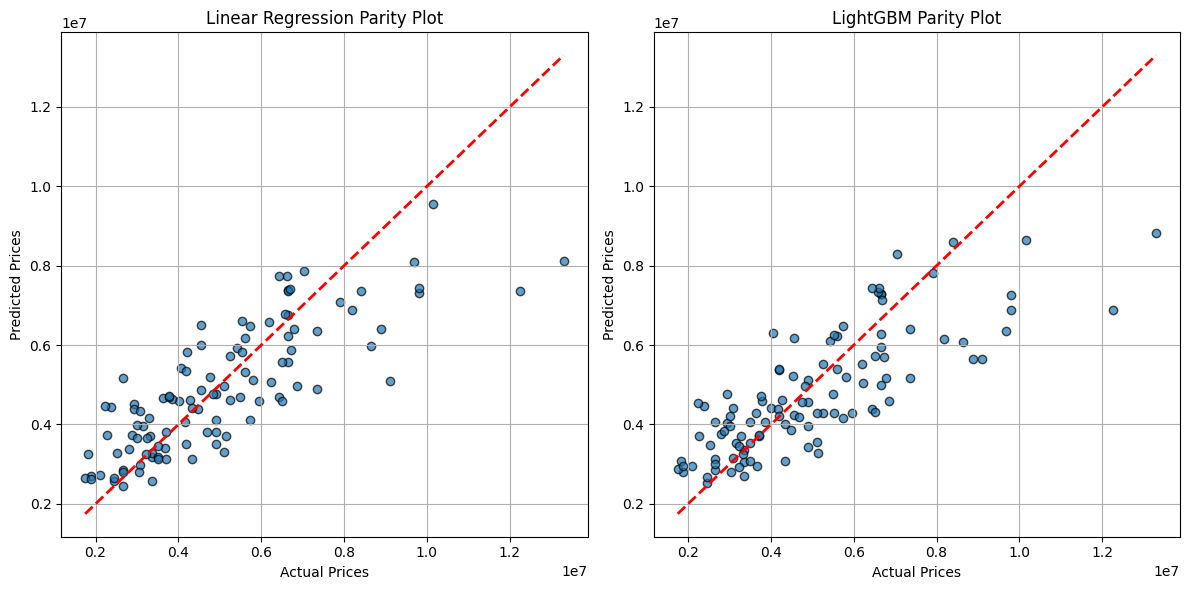

In [ ]:
# Create parity plot for Linear Regression
plt.figure(figsize=(12, 6))

# Subplot 1: Linear Regression Parity Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression Parity Plot')
plt.grid(True)

# Subplot 2: LightGBM Parity Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_lgb, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('LightGBM Parity Plot')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


**Resiudal Plot**

Since the points are randmoly scattered ariund the residual line therefore a linear model is effective for modeling the dataset.

In [ ]:
# Calculate residuals for Linear Regression and LightGBM
residuals_lr = y_test - y_pred_lr  # Residuals for Linear Regression
residuals_lgb = y_test - y_pred_lgb  # Residuals for LightGBM


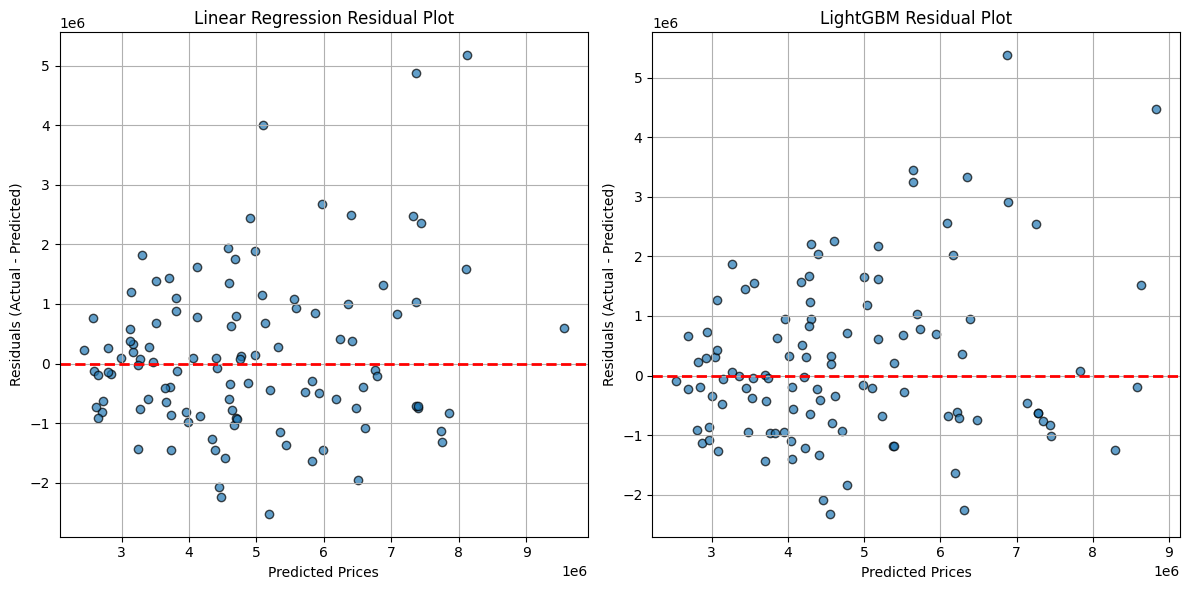

In [ ]:
import matplotlib.pyplot as plt

# Create residual plot for Linear Regression and LightGBM
plt.figure(figsize=(12, 6))

# Subplot 1: Linear Regression Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_lr, residuals_lr, edgecolors=(0, 0, 0), alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Linear Regression Residual Plot')
plt.grid(True)

# Subplot 2: LightGBM Residual Plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred_lgb, residuals_lgb, edgecolors=(0, 0, 0), alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('LightGBM Residual Plot')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


**Density Plot**

The plots of both models show slight positive skewnees with unimodal which means that the data is mostly evenly distributed around the central value, and have similar frequencies of observations on both sides.

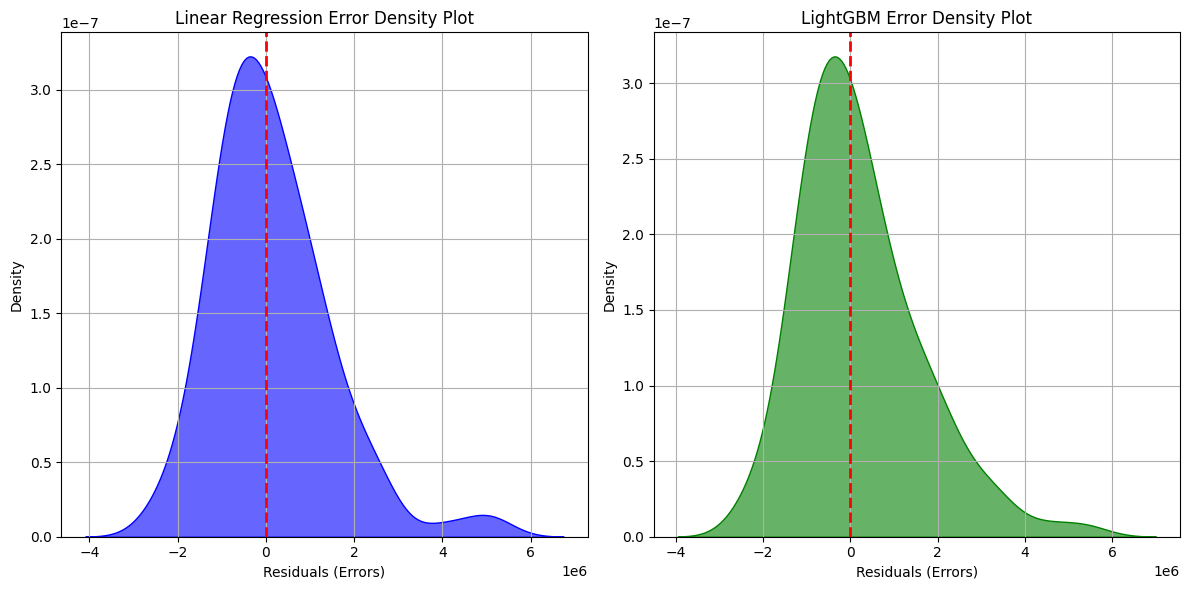

In [ ]:
import seaborn as sns

# Create density plot for Linear Regression and LightGBM
plt.figure(figsize=(12, 6))

# Subplot 1: Linear Regression Error Density Plot
plt.subplot(1, 2, 1)
sns.kdeplot(residuals_lr, fill=True, color='blue', alpha=0.6)
plt.axvline(x=0, color='red', linestyle='--', lw=2)
plt.title('Linear Regression Error Density Plot')
plt.xlabel('Residuals (Errors)')
plt.grid(True)

# Subplot 2: LightGBM Error Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(residuals_lgb, fill=True, color='green', alpha=0.6)
plt.axvline(x=0, color='red', linestyle='--', lw=2)
plt.title('LightGBM Error Density Plot')
plt.xlabel('Residuals (Errors)')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


**Box Plot**

Light GBM model have less outliners than the Linear Regression model however, the interquartile range of the Linear Regression model is less than the Light GBM model.

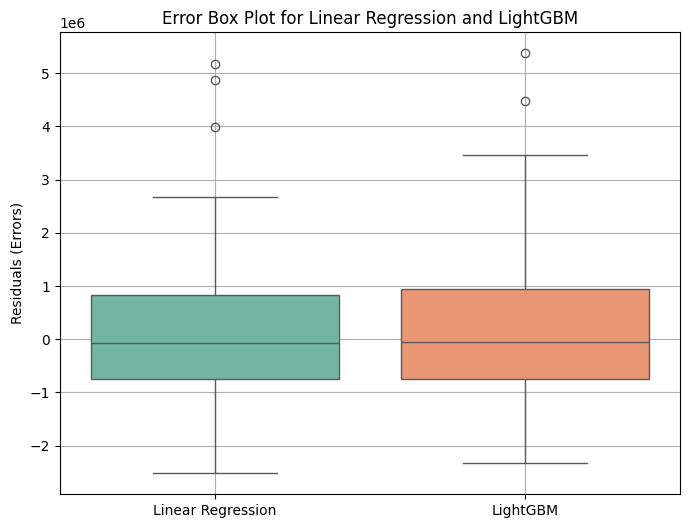

In [ ]:
# Create box plot for Linear Regression and LightGBM errors
plt.figure(figsize=(8, 6))

# Combine the residuals into a DataFrame for easier plotting
import pandas as pd
df_errors = pd.DataFrame({
    'Linear Regression': residuals_lr,
    'LightGBM': residuals_lgb
})

# Box plot
sns.boxplot(data=df_errors, palette="Set2")
plt.title('Error Box Plot for Linear Regression and LightGBM')
plt.ylabel('Residuals (Errors)')
plt.grid(True)

# Show the box plot
plt.show()


# **Conslusion**
In colclusion the Linear Regression model gives better performance than the Light GBM model.